In [1]:
!pip install -q diffusers transformers torch pillow

In [2]:
import os
import re
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from io import BytesIO
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display
import gc

print("✓ All dependencies installed!")

✓ All dependencies installed!



🎬 QUOTE2SCENE - Generate a Single Poster
🚀 Using device: cpu
📦 Loading Stable Diffusion model: runwayml/stable-diffusion-v1-5


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✓ Model loaded successfully!

📝 Quote: Every sunrise brings a new hope.
🔑 Keywords: every, sunrise, brings, new, hope
🎨 Prompt: A beautiful, inspiring scene featuring every, sunrise, brings, new, hope. Professional photography, high quality, vibrant colors, cinematic lighting, motivational atmosphere, 4k, masterpiece
⏳ Generating image...


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Image generated successfully!
💾 Saved image: /content/motivational_poster.png


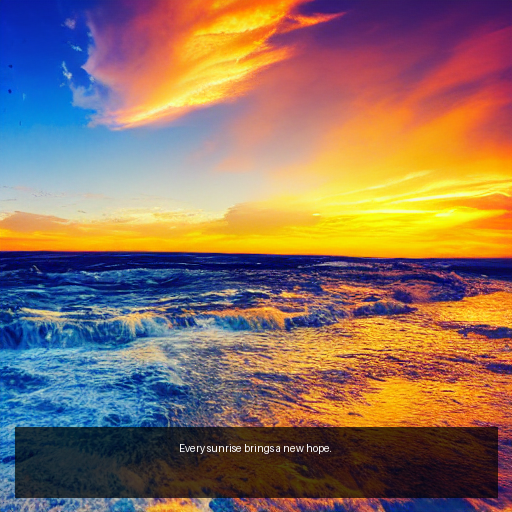


✅ Poster generated successfully!


In [3]:
# ============================================
# 📸 QUOTE2SCENE - Generate Image from Quote
# ============================================

import torch, re, gc
from diffusers import StableDiffusionPipeline
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPImage

class Quote2Scene:
    def __init__(self, model_id="runwayml/stable-diffusion-v1-5"):
        """Initialize Quote2Scene model for Colab"""
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"🚀 Using device: {self.device}")
        print(f"📦 Loading Stable Diffusion model: {model_id}")

        # Load model with memory optimization
        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
            safety_checker=None
        ).to(self.device)

        if self.device == "cuda":
            self.pipe.enable_attention_slicing()
            torch.cuda.empty_cache()

        print("✓ Model loaded successfully!")

    def extract_keywords(self, quote, num_keywords=5):
        """Extract main keywords from the quote"""
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'is', 'was', 'are', 'be', 'been', 'being', 'have', 'has', 'had',
            'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might',
            'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she',
            'it', 'we', 'they', 'what', 'which', 'who', 'when', 'where', 'why', 'how'
        }
        words = re.findall(r'\b[a-z]+\b', quote.lower())
        keywords = [w for w in words if w not in stop_words and len(w) > 2]
        seen, unique = set(), []
        for w in keywords:
            if w not in seen:
                seen.add(w)
                unique.append(w)
        return unique[:num_keywords]

    def create_prompt(self, keywords):
        """Form a descriptive prompt from keywords"""
        keyword_str = ", ".join(keywords)
        return (f"A beautiful, inspiring scene featuring {keyword_str}. "
                "Professional photography, high quality, vibrant colors, "
                "cinematic lighting, motivational atmosphere, 4k, masterpiece")

    def generate_image(self, quote, num_steps=30, guidance_scale=7.5, seed=None):
        """Generate an image from a quote"""
        print(f"\n📝 Quote: {quote}")
        keywords = self.extract_keywords(quote)
        print(f"🔑 Keywords: {', '.join(keywords)}")
        prompt = self.create_prompt(keywords)
        print(f"🎨 Prompt: {prompt}")

        generator = (torch.Generator(self.device).manual_seed(seed)
                     if seed is not None else None)

        print("⏳ Generating image...")
        with torch.no_grad():
            image = self.pipe(
                prompt,
                num_inference_steps=num_steps,
                guidance_scale=guidance_scale,
                height=512,
                width=512,
                generator=generator
            ).images[0]
        print("✓ Image generated successfully!")
        torch.cuda.empty_cache()
        return image

    def overlay_quote(self, image, quote, font_size=32, bg_opacity=180):
        """Overlay quote text on image"""
        img = image.copy()
        draw = ImageDraw.Draw(img, 'RGBA')
        try:
            font = ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
        except:
            font = ImageFont.load_default()

        margin = 30
        max_width = img.width - (2 * margin)
        lines, line = [], ""
        for word in quote.split():
            test = f"{line}{word} "
            if draw.textlength(test, font=font) > max_width:
                lines.append(line.strip())
                line = f"{word} "
            else:
                line = test
        if line:
            lines.append(line.strip())

        line_height = font_size + 8
        total_height = len(lines) * line_height
        start_y = img.height - total_height - margin

        # Background box
        draw.rectangle(
            [(margin - 15, start_y - 15),
             (img.width - margin + 15, start_y + total_height + 15)],
            fill=(0, 0, 0, bg_opacity)
        )

        # Draw each line centered
        y = start_y
        for line in lines:
            text_width = draw.textlength(line, font=font)
            x = (img.width - text_width) // 2
            draw.text((x, y), line, font=font, fill=(255, 255, 255, 255))
            y += line_height

        return img

    def quote_to_scene(self, quote, output_path="motivational_poster.png",
                       num_steps=30, add_text=True):
        """Full pipeline: Quote ➜ Image ➜ Save ➜ Display"""
        image = self.generate_image(quote, num_steps=num_steps)
        if add_text:
            image = self.overlay_quote(image, quote)
        image.save(output_path)
        print(f"💾 Saved image: {output_path}")
        display(IPImage(output_path))
        return image


# ============================================
# 🚀 Example usage (Single Image Generation)
# ============================================
print("\n" + "="*60)
print("🎬 QUOTE2SCENE - Generate a Single Poster")
print("="*60)

model = Quote2Scene()
quote = "Every sunrise brings a new hope."
model.quote_to_scene(quote, output_path="/content/motivational_poster.png")

gc.collect()
torch.cuda.empty_cache()

print("\n✅ Poster generated successfully!")
